# Exploring the BTC data and trying different prediciton models

In [30]:
import math
import os
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
np.random.seed(1)

## Data Cleaning

In [31]:
#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_csv(os.path.join("lib", "btc_apr_1_2012_to_apr_14_2019.csv"), thousands=',')
assert(df.isnull().values.any()==False)

df = df.rename(index=str, columns={'Vol.':'Vol', 'Change %':'Change'})

df['Date'] = pd.to_datetime(df.Date, infer_datetime_format=True)
df.index = df['Date']
df['Vol'] = df['Vol'].apply(lambda x: float(x[:-1]))
df['Change'] = df['Change'].apply(lambda x: float(x[:-1]))

#print the head
df.head()

main_column = 'Price' 

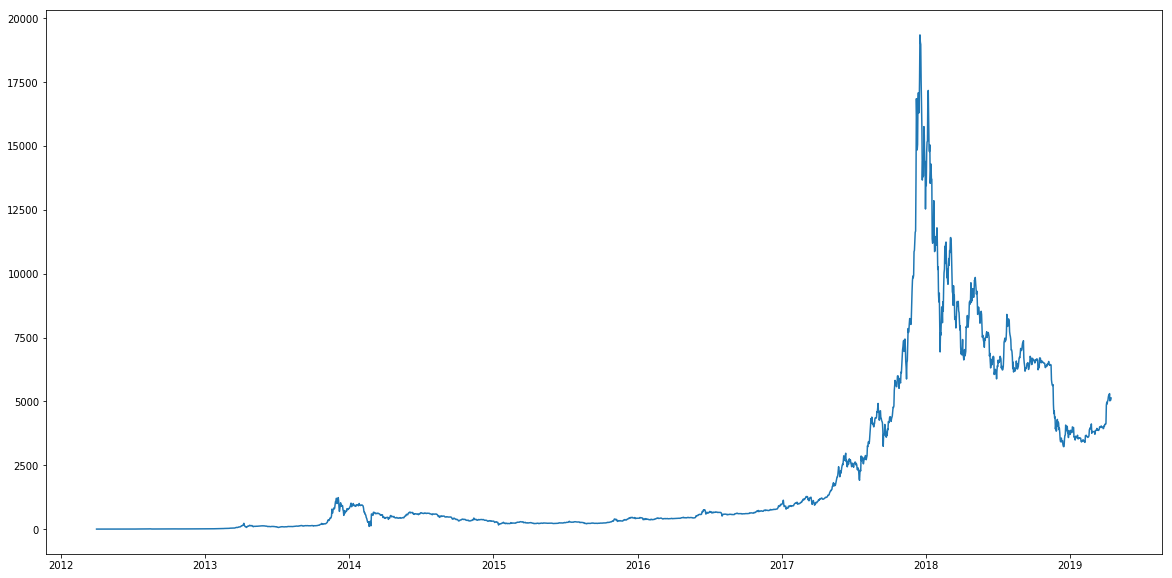

In [27]:
#plot
plt.plot(df[[main_column]], label='Price history')

## Trend, Seasonal, and Residual features with interactive plot

In [36]:
import statsmodels.api as sm
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

s = sm.tsa.seasonal_decompose(np.flip(df[main_column].values), freq=60)

df['Trend'] = s.trend
df['Seasonal'] = s.seasonal
df['Residual'] = s.resid

trace1 = go.Scatter(x = np.arange(0, len(s.trend), 1),y = s.trend,mode = 'lines',name = 'Trend',
    line = dict(color = ('rgb(244, 146, 65)'), width = 4))
trace2 = go.Scatter(x = np.arange(0, len(s.seasonal), 1),y = s.seasonal,mode = 'lines',name = 'Seasonal',
    line = dict(color = ('rgb(66, 244, 155)'), width = 2))

trace3 = go.Scatter(x = np.arange(0, len(s.resid), 1),y = s.resid,mode = 'lines',name = 'Residual',
    line = dict(color = ('rgb(209, 244, 66)'), width = 2))

trace4 = go.Scatter(x = np.arange(0, len(s.observed), 1),y = s.observed,mode = 'lines',name = 'Observed',
    line = dict(color = ('rgb(66, 134, 244)'), width = 2))

df['Trend'] = s.trend
df['Seasonal'] = s.seasonal
df['Residual'] = s.resid

data = [trace1, trace2, trace3, trace4]
layout = dict(title = 'Seasonal decomposition', xaxis = dict(title = 'Time'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='seasonal_decomposition')

## Technical Indicators

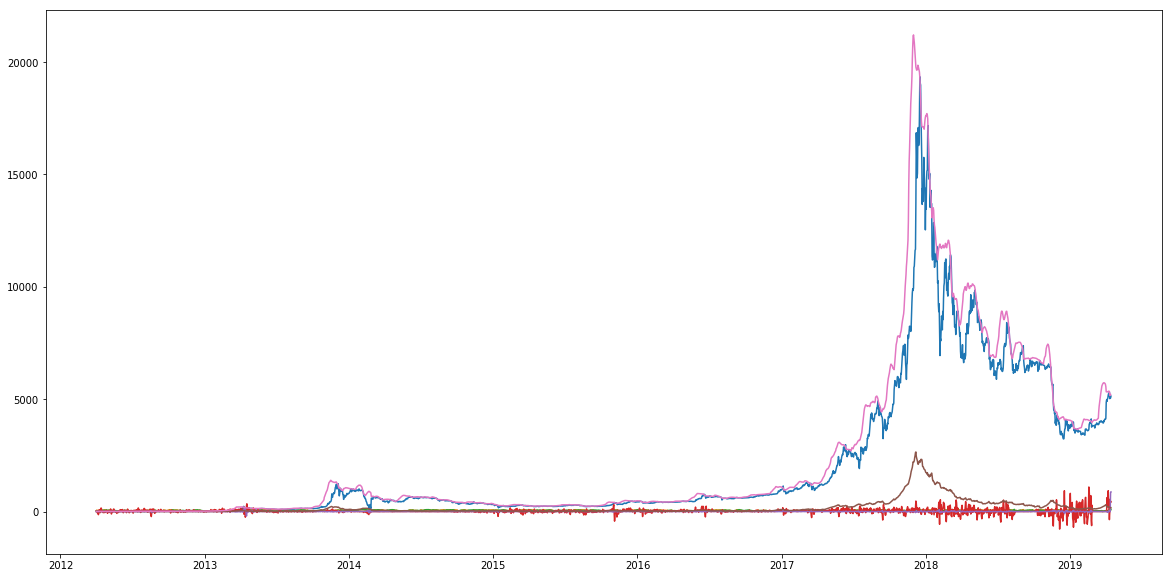

In [39]:
import ta as ta

df['rsi'] = ta.momentum.rsi(df['Price'])
df['mfi'] = ta.momentum.money_flow_index(df['High'], df['Low'], df['Price'], df['Vol'])
df['adi'] = ta.volume.acc_dist_index(df['High'], df['Low'], df['Price'], df['Vol'])
df['vpt'] = ta.volume.volume_price_trend(df['Price'], df['Vol'])
df['atr'] = ta.volatility.average_true_range(df['High'], df['Low'], df['Price'])
df['bb'] = ta.volatility.bollinger_hband(df['Price'])

plt.plot(df[[main_column, 'rsi','mfi', 'adi', 'vpt', 'atr', 'bb']])
# ta_indicators = ta.add_all_ta_features(df, "Open", "High", "Low", "Price", "Vol", fillna=True)

## Train/Dev split

In [18]:
#creating dataframe with date and the target variable
data = df.sort_index(ascending=True, axis=0)

#splitting into train and validation
dev_size = 300
train = data[:-dev_size]
dev = data[-dev_size:]

data.shape, train.shape, dev.shape

((2570, 10), (2270, 10), (300, 10))

## Moving Average

In [19]:
preds = []
for i in range(0,dev_size):
    a = train[main_column][len(train)-dev_size+i:].sum() + dev[main_column][:i].sum()
    b = a/dev_size
    preds.append(b)
    
#calculate rmse
rms=np.sqrt(np.mean(np.power((np.array(dev[main_column])-preds),2)))
rms

2405.7776802589447

/anaconda3/envs/cs230/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


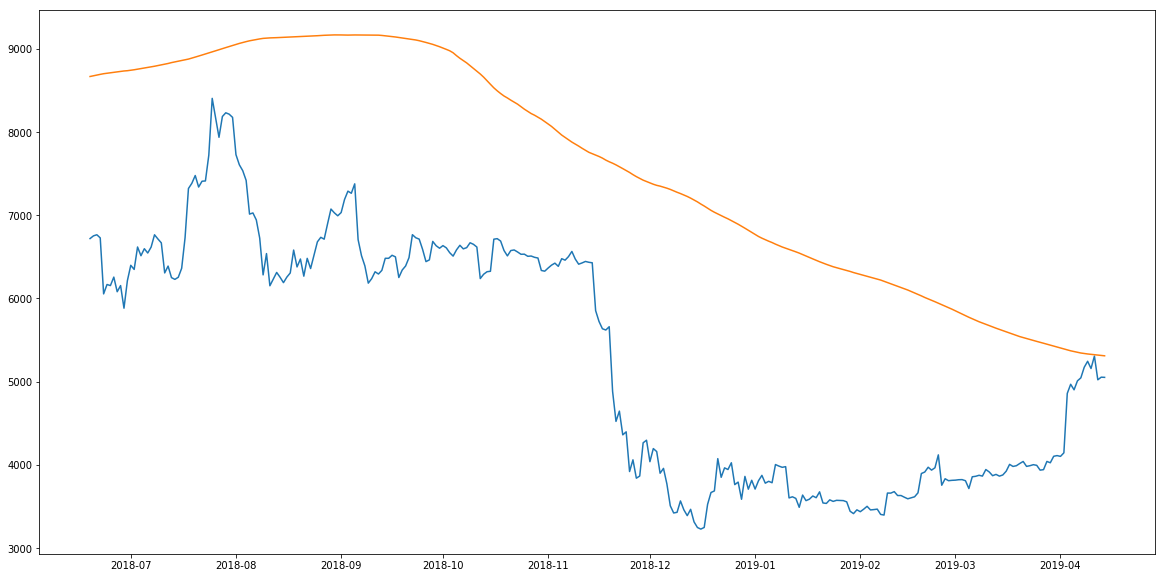

In [9]:
#plot
dev['Moving Average'] = preds
# plt.plot(train['Open'])
plt.plot(dev[[main_column, 'Moving Average']])

## ARIMA forecasting

In [41]:
from statsmodels.tsa.arima_model import ARIMA

train_list, test_list = np.asarray(train[main_column]), np.asarray(dev[main_column])
history = [x for x in train_list]

predictions = []
for t in range(len(test_list)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_list[t]
    history.append(obs)

#calculate rmse
rms=np.sqrt(np.mean(np.power((np.array(dev[main_column])-predictions),2)))
print('ARIMA RMSE: %.3f' % rms)

/anaconda3/envs/cs230/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA RMSE: 2055.586


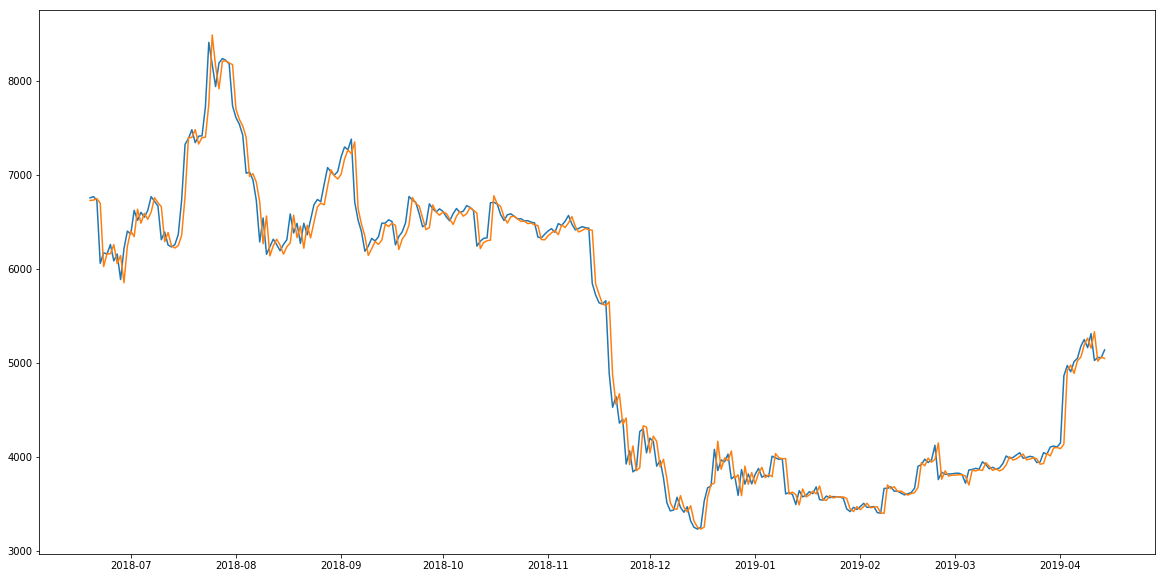

In [71]:
dev['ARIMA'] =predictions
# plt.plot(train['Open'])
plt.plot(dev[[main_column, 'ARIMA']])

## VAR forecasting

In [20]:
from statsmodels.tsa.vector_ar.var_model import VAR

history = train.copy()
predictions = []
for t in range(len(dev)):
    model = VAR(endog=np.asarray(history[['Price', 'Open', 'High', 'Low', 'Vol', "Change"]]))
    model_fit = model.fit()
    output = model_fit.forecast(model_fit.y, steps=1)
    yhat = output[0][0]
    predictions.append(yhat)
    obs = dev[['Price', 'Open', 'High', 'Low', 'Vol', "Change"]].iloc[[t]]
    history = history.append(obs)
    

#calculate rmse
rms=np.sqrt(np.mean(np.power((np.array(dev[main_column])-predictions),2)))
print('RMSE: %.3f' % rms)

RMSE: 172.128


/anaconda3/envs/cs230/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



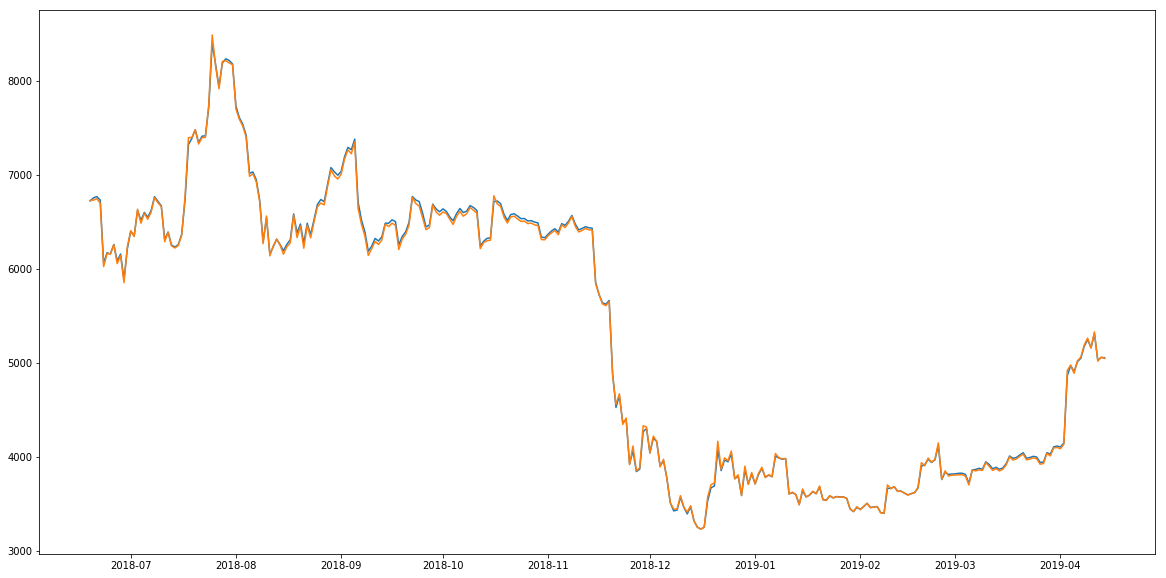

In [44]:
#plot
dev['VAR'] = predictions
# plt.plot(train['Open'])
plt.plot(dev[[main_column, 'VAR']])

# VARMAX residuals

(2270, 6)


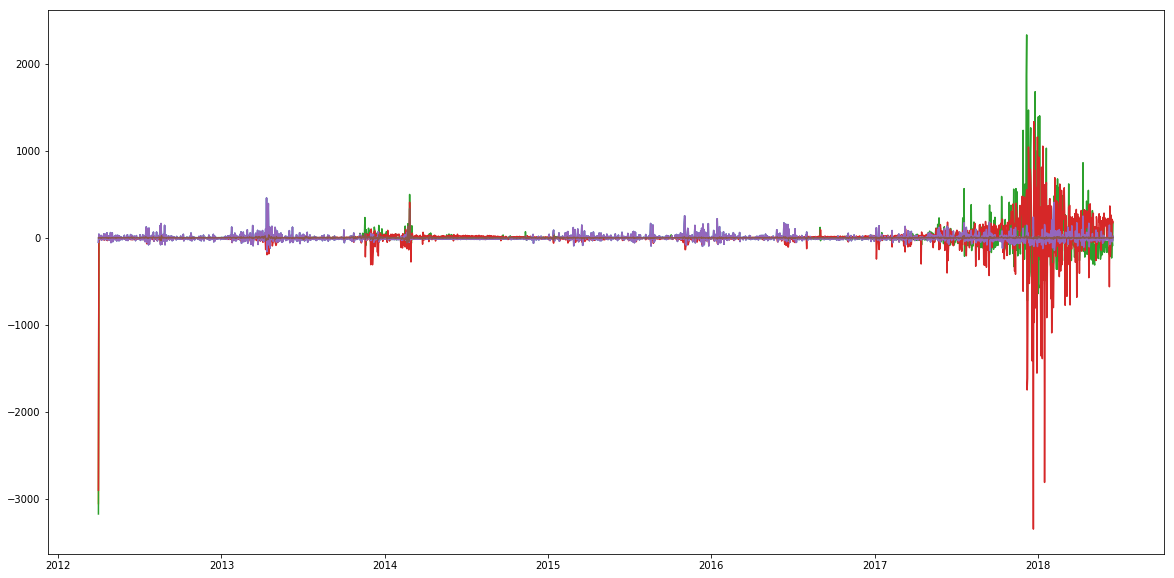

In [57]:
from statsmodels.tsa.statespace.varmax import VARMAX

model = VARMAX(endog=np.asarray(train[['Price', 'Open', 'High', 'Low', 'Vol', "Change"]]))
model_fit = model.fit()

train['VAR_Price'] = model_fit.resid[:, 0]
train['VAR_Open'] = model_fit.resid[:, 1]
train['VAR_High'] = model_fit.resid[:, 2]
train['VAR_Low'] = model_fit.resid[:, 3]
train['VAR_Price'] = model_fit.resid[:, 4]
train['VAR_Change'] = model_fit.resid[:, 5]

plt.plot(train[['VAR_Price','VAR_Open','VAR_High','VAR_Low', 'VAR_Price', 'VAR_Change']])

## Kalman Filter smoothing

In [72]:
from pykalman import KalmanFilter

kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
measurements = train[['Price']].values
results = kf.em(measurements).smooth(measurements)

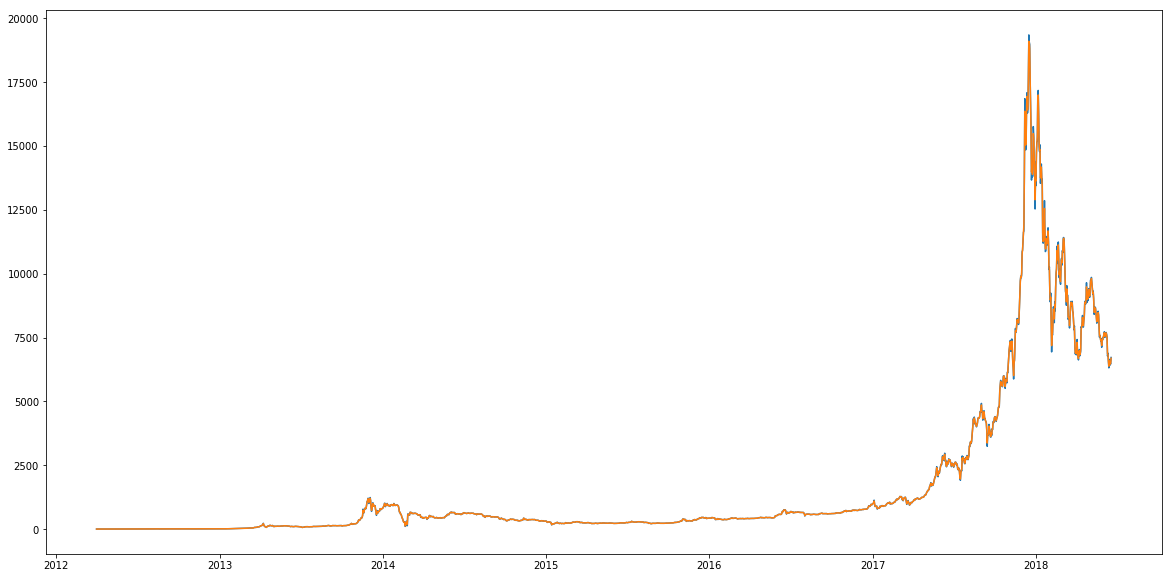

In [68]:
train['Price_smooth'] = results[0]
plt.plot(train[['Price_smooth']])